In [20]:
import numpy as np
import pandas as pd
import datetime as dt

from collections import OrderedDict
import os

In [3]:
def time_to_div(day):
    """fraction of years until next dividend"""
    
    # get offset 
    divs = ["09-15", "06-16", "03-17", "12-16"]
    div_dates = sorted([dt.datetime.strptime(f'{day.year}-{date}', '%Y-%m-%d') for date in divs])
    
    # get next dividend 
    for date in div_dates:
        if day <= date:
            return (date - day).days / 365
    
    return (div_dates[0].replace(year=day.year + 1) - day).days / 365

#### Algorithm

recombining tree with proportional dividends as described by hull, 21.3

quarterly dividend payout for SPY, $\delta$ set at 0.03556

parameters

In [17]:
# inputs
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.1  # risk free rate
sig = 0.2  # annualized volatility
N = 2500 # number of time steps
payoff = "call"

# initialization
dT = float(T) / N  # Delta t
u = np.exp(sig * np.sqrt(dT))  # up factor
d = 1.0 / u  # down factor

a = np.exp(r * dT)  # risk free compound return
p = (a - d) / (u - d)  # risk neutral up probability
q = 1.0 - p  # risk neutral down probability

dividend set up

In [18]:
div_yield = 0.003556 # quarterly payout
div_freq = 0.25 # quarterly
div_offset = time_to_div(dt.datetime.today()) # time in years until first dividend

# number of dividends that will occur in option lifetime
num_div = int((T - div_offset) / div_freq) + 1

# times in years at which dividends will occur
div_times = [div_offset + n*div_freq for n in range(0, num_div) ]

algorithm

In [19]:
# initialize price vector
V = np.zeros(N + 1)  
S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)]) 

# adjusting price for number of dividends that has occured
S_T = S_T * (1 - div_yield)**num_div

# payoff function
if payoff == "call":
    V[:] = np.maximum(S_T - K, 0.0)
elif payoff == "put":
    V[:] = np.maximum(K - S_T, 0.0)

# backwards iteration
for i in range(N - 1, -1, -1):
    
    # the price vector is overwritten at each step
    V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1]) 
    
    # obtain the price at the previous time step
    S_T = S_T * u  

    # if we pass a dividend time, we can divide by (1-div)
    if div_times:
        if i * dT < div_times[-1]:
            S_T = S_T / (1 - div_yield)
            div_times.pop(-1)
    
    # american early exercise 
    if payoff == "call":
        V = np.maximum(V, S_T - K)
    elif payoff == "put":
        V = np.maximum(V, K - S_T)
            

print(f"American {payoff} Price: ", V[0])

American call Price:  12.259913945834006


#### Improvements

1. risk-free rate forward curve


In [93]:
rfr = pd.read_csv('daily-treasury-rates.csv', index_col=0)
rfr.index = pd.to_datetime(rfr.index)
rfr.columns = [1/12, 1/6, 1/4, 1/3, 1/2, 1, 2, 3, 5, 7, 10, 20, 30]

In [39]:
def flat_r(N):
    return np.array([0.054]*N)

In [114]:
from scipy import interpolate


def curve_r(N, T, calc_day):

    rf = rfr.loc[calc_day]
    y = np.array(rf.values) / 100
    x = rf.index.tolist()
        
    cs = interpolate.CubicSpline(x, y)
    return cs(np.linspace(0, T, N))

#curve = curve_r(2500, 1, dt.datetime(2023, 10, 2))


#### functionized

In [133]:
def american_option(S0, K, calc_day, expiry, sig, payoff, rf, div_info):
    """  
    Parameters:
        S0 - spot price
        K - strike price
        calc_day - day of calculation
        expiry - expiration date of option
        sig - annualized vol
        payoff - 'call' or 'put'
        rf - 'flat' or 'curve'
        div_info - [yield, freq, offset]
    """

    N = 1_000
    T = (expiry-calc_day).days / 365
    
    if rf=='flat':
        r = flat_r(N)
    else:
        r = curve_r(N, T, calc_day)

    # divident init
    div_yield = div_info[0] # quarterly payout
    div_freq = div_info[1] # quarterly
    div_offset = div_info[2] # time in years until first dividend

    # number of dividends that will occur in option lifetime
    num_div = int((T - div_offset) / div_freq) + 1

    # times in years at which dividends will occur
    div_times = [div_offset + n*div_freq for n in range(0, num_div) ]
            
    # initialization
    dT = float(T) / N  # Delta t
    u = np.exp(sig * np.sqrt(dT))  # up factor
    d = 1.0 / u  # down factor

    a = np.exp(r * dT)  # risk free compound return
    p = (a - d) / (u - d)  # risk neutral up probability
    q = 1.0 - p  # risk neutral down probability
    
    
    # initialize price vector
    V = np.zeros(N + 1)  
    S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)]) 

    # adjusting price for number of dividends that has occured
    S_T = S_T * (1 - div_yield)**num_div

    # payoff function
    if payoff == "call":
        V[:] = np.maximum(S_T - K, 0.0)
    elif payoff == "put":
        V[:] = np.maximum(K - S_T, 0.0)

    # backwards iteration
    for i in range(N - 1, -1, -1):
        
        # the price vector is overwritten at each step
        V[:-1] = np.exp(-r[i] * dT) * (p[i] * V[1:] + q[i] * V[:-1]) 
        
        # obtain the price at the previous time step
        S_T = S_T * u  

        # if we pass a dividend time, we can divide by (1-div)
        if div_times:
            if i * dT < div_times[-1]:
                S_T = S_T / (1 - div_yield)
                div_times.pop(-1)
        
        # american early exercise 
        if payoff == "call":
            V = np.maximum(V, S_T - K)
        elif payoff == "put":
            V = np.maximum(V, K - S_T)
                

    return V[0]

#### Testing

In [190]:
daily_chains = OrderedDict()
files = sorted(os.listdir('spy_data'))

for file in files:
    if file[-4:] == '.csv':
        df = pd.read_csv('spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = dt.datetime.combine(df['quote_datetime'][0].date(), dt.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & (df['T'] >= 20) & (df['T'] <= 365)]
                    
        calls = df.loc[df['option_type']=='C'][['quote_date', 'expiration', 'T','implied_volatility', 'active_underlying_price', 'strike', 'bid', 'ask']]
        puts = df.loc[df['option_type']=='P'][['quote_date','expiration', 'T', 'implied_volatility', 'active_underlying_price', 'strike', 'bid', 'ask']]
        
        daily_chains[file[-14:-4]] = {'calls':calls, 'puts':puts}

In [205]:
test_daystr = '2023-10-02'
test_daydt = dt.datetime(2023, 10, 2)
test_day = daily_chains[test_daystr]
print(test_day['calls']['T'].unique())

ttm = 25
test_c = test_day['calls']
test_c = test_c.loc[test_c['T']==ttm].sort_values(by='strike')


[ 25  32  39  46  74  88 109 137 165 178 263 270 354 364]


In [206]:
div_info = [0.003556, 0.25, time_to_div(test_daydt)]
test_c['cprice'] = test_c.apply(lambda row: 
    american_option(row['active_underlying_price'],
                    row['strike'],
                    row['quote_date'],
                    row['expiration'],
                    row['implied_volatility'],
                    'call',
                    'curve', 
                    div_info), axis=1)

test_c['mid'] = test_c.apply(lambda row: (row['bid'] + row['ask']) / 2, axis=1)

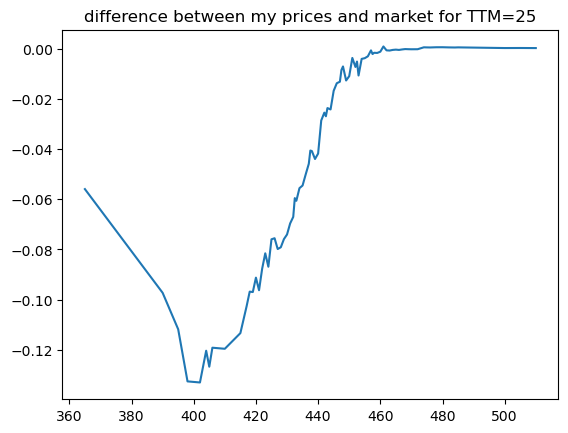

In [207]:
import matplotlib.pyplot as plt

plt.plot(test_c['strike'], test_c['cprice'] - test_c['mid'])

plt.title(f'difference between my prices and market for TTM={ttm}')
plt.show()

In [194]:
len(test_c[(test_c['cprice'] > test_c['bid']) & (test_c['cprice'] < test_c['ask'])]) / len(test_c)

0.975

In [195]:
div_info = [0.003556, 0.25, time_to_div(test_daydt)]
test_c['cprice'] = test_c.apply(lambda row: 
    american_option(row['active_underlying_price'],
                    row['strike'],
                    row['quote_date'],
                    row['expiration'],
                    row['implied_volatility'],
                    'call',
                    'curve', 
                    div_info), axis=1)

test_c['mid'] = test_c.apply(lambda row: (row['bid'] + row['ask']) / 2, axis=1)

In [197]:
div_info = [0.003556, 0.25, time_to_div(test_daydt)]

for day in daily_chains:
    c = daily_chains[day]['calls']
    p = daily_chains[day]['puts']
    
    c['cprice'] = c.apply(lambda row: 
    american_option(row['active_underlying_price'],
                    row['strike'],
                    row['quote_date'],
                    row['expiration'],
                    row['implied_volatility'],
                    'call',
                    'curve', 
                    div_info), axis=1)
    c['mid'] = c.apply(lambda row: (row['bid'] + row['ask']) / 2, axis=1)
    c_pct = len(c.loc[(c['cprice'] > c['bid']) & (c['cprice'] < c['ask'])]) / len(c)
    
    
    p['pprice'] = p.apply(lambda row: 
    american_option(row['active_underlying_price'],
                    row['strike'],
                    row['quote_date'],
                    row['expiration'],
                    row['implied_volatility'],
                    'put',
                    'curve', 
                    div_info), axis=1)
    p['mid'] = p.apply(lambda row: (row['bid'] + row['ask']) / 2, axis=1)
    p_pct = len(p.loc[(p['pprice'] > p['bid']) & (p['pprice'] < p['ask'])]) / len(p)

    
    print(day, 'call MVE:', np.mean(np.abs(c['cprice'] - c['mid'])))
    print(day, 'put MVE:', np.mean(np.abs(p['pprice'] - p['mid'])))
    
    
    
    break
    
    
    

2023-10-02 call MVE: 0.1004466767065631
2023-10-02 put MVE: 0.16372832321265374


In [198]:
print(c_pct, p_pct)

0.5808580858085809 0.5531697341513292


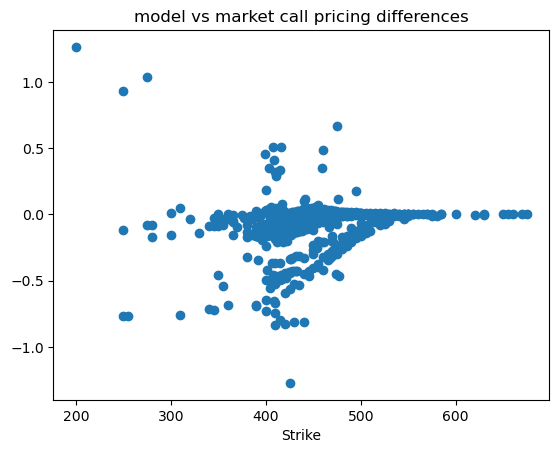

In [202]:
plt.scatter(c['strike'], c['cprice']-c['mid'])
plt.title('model vs market call pricing differences')
plt.xlabel('Strike')
plt.show()

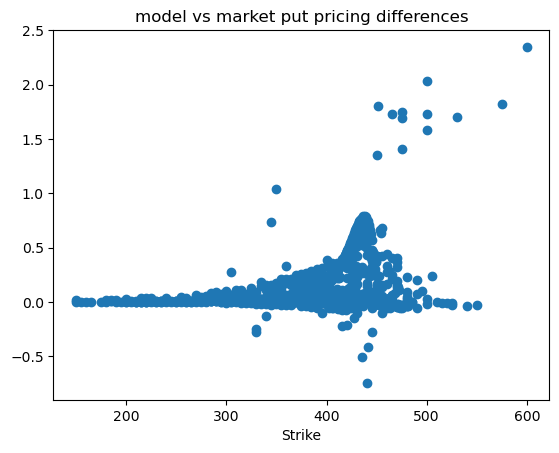

In [204]:
plt.scatter(p['strike'], p['pprice']-p['mid'])
plt.title('model vs market put pricing differences')
plt.xlabel('Strike')
plt.show()